# Resnet-18

- Channels can be visualised after direct logit attribution to find maximally activating channels for a given class.

Issues

- I don't know whether these visualisations are correct, OpenAI Microscope is down so I can't verify them. The visualisations for layer 3 are good but for layer 4 are indecipherable.  

### Setup and Helper functions

In [ ]:
!pip install --quiet git+https://github.com/atagade/lucent

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.2/228.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.1 MB/s eta 0:00:00


In [ ]:
import torch
import urllib.request 
import numpy as np
import collections
from functools import partial
from PIL import Image
from lucent.modelzoo import custom_resnet
from lucent.optvis import objectives, transform, param, render
from lucent.optvis.render import hook_model

In [ ]:
import urllib.request  # the lib that handles the url stuff
labels_str = ""
for line in urllib.request.urlopen("https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt"):
    labels_str += line.decode('utf-8')
labels = [line[line.find(" "):].strip() for line in labels_str.split("\n")]
labels = [label[label.find(" "):].strip().replace("_", " ") for label in labels]
labels = ["dummy"] + labels

In [ ]:
!wget https://distill.pub/2018/building-blocks/examples/input_images/dog_cat.jpeg

--2023-05-11 05:23:32--  https://distill.pub/2018/building-blocks/examples/input_images/dog_cat.jpeg
Resolving distill.pub (distill.pub)... 151.101.65.195, 151.101.1.195
Connecting to distill.pub (distill.pub)|151.101.65.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17153 (17K) [image/jpeg]
Saving to: ‘dog_cat.jpeg’

dog_cat.jpeg        100%[===================>]  16.75K  --.-KB/s    in 0s      

2023-05-11 05:23:32 (86.0 MB/s) - ‘dog_cat.jpeg’ saved [17153/17153]



In [ ]:
def raw_class_spatial_attr(img, layer, label, transforms=None, override=None):
  """How much did spatial positions at a given layer effect a output class?"""

  img = torch.tensor(np.transpose(img, [2, 0, 1])).to('cpu')
  normalize = (
      transform.preprocess_inceptionv1()
      if model._get_name() == "InceptionV1"
      else transform.normalize()
  )
  transforms = [
      normalize,
      torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
  ]

  transforms_f = transform.compose(transforms)
  img = img.unsqueeze(0)
  img = transforms_f(img)
  
  scores = model.forward(img)
  acts = activations[layer.replace('_','.')][0]

  score = scores[0, labels.index(label)]
  grad = torch.autograd.grad(score, acts)[0]
  
  return torch.sum(acts * grad, axis = -1)[0].detach()

## Layer 3 Visualisations

### Maximally activating channels for Labrador Retreiver in layer 3

#### Collecting channels

In [ ]:
channel_list = []

layers = ['layer3_0_conv1',
 'layer3_0_bn1',
 'layer3_0_relu',
 'layer3_0_conv2',
 'layer3_0_bn2',
 'layer3_0_downsample_0',
 'layer3_0_downsample_1',
 'layer3_1_conv1',
 'layer3_1_bn1',
 'layer3_1_relu',
 'layer3_1_conv2',
 'layer3_1_bn2',]

label = 'Labrador retriever'

for l in layers:
  model = custom_resnet.resnet18(weights = "pretrained").to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  channel_list.append(attr.max(-1)[0].topk(1)[1])

  for handle in handles:
    handle.remove()

In [ ]:
print(channel_list)

[tensor([217]), tensor([217]), tensor([217]), tensor([134]), tensor([141]), tensor([140]), tensor([111]), tensor([187]), tensor([169]), tensor([169]), tensor([181]), tensor([181])]


#### Visualising all channels and combined channel objective

100%|██████████| 512/512 [00:32<00:00, 15.55it/s]



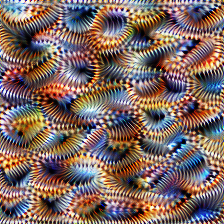
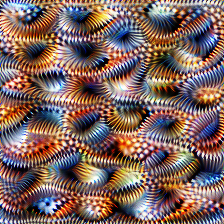
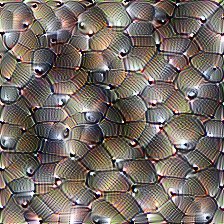
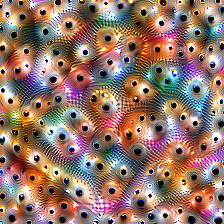
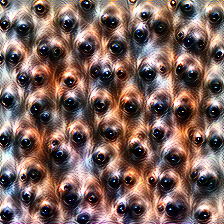
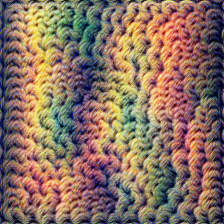
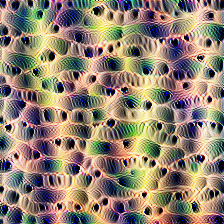
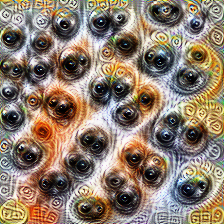
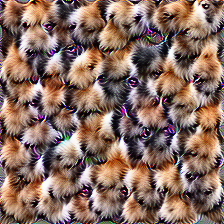
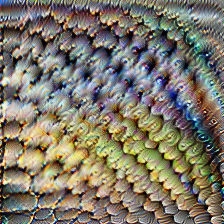
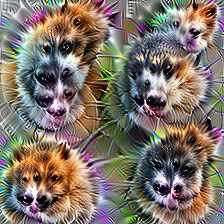
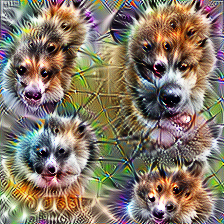
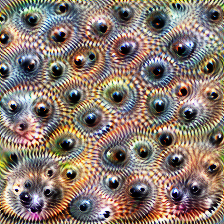

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = custom_resnet.resnet18(weights = "pretrained").to(device).eval()

param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0].item(), batch = 0) + objectives.channel(layers[1],channel_list[1].item(), batch = 1) + objectives.channel(layers[2],channel_list[2].item(), batch = 2) + objectives.channel(layers[3],channel_list[3].item(), batch = 3) + \
      objectives.channel(layers[4],channel_list[4].item(), batch = 4) + objectives.channel(layers[5],channel_list[5].item(), batch = 5) + objectives.channel(layers[6],channel_list[6].item(), batch = 6) + objectives.channel(layers[7],channel_list[7].item(), batch = 7) + \
      objectives.channel(layers[8],channel_list[8].item(), batch = 8) + objectives.channel(layers[9],channel_list[9].item(), batch = 9) + objectives.channel(layers[10],channel_list[10].item(), batch = 10) + objectives.channel(layers[11],channel_list[11].item(), batch = 11) + \
      objectives.channel(layers[0],channel_list[0].item(), batch = 12) + objectives.channel(layers[1],channel_list[1].item(), batch = 12) + objectives.channel(layers[2],channel_list[2].item(), batch = 12) + objectives.channel(layers[3],channel_list[3].item(), batch = 12) + \
      objectives.channel(layers[4],channel_list[4].item(), batch = 12) + objectives.channel(layers[5],channel_list[5].item(), batch = 12) + objectives.channel(layers[6],channel_list[6].item(), batch = 12) + objectives.channel(layers[7],channel_list[7].item(), batch = 12) + \
      objectives.channel(layers[8],channel_list[8].item(), batch = 12) + objectives.channel(layers[9],channel_list[9].item(), batch = 12) + objectives.channel(layers[10],channel_list[10].item(), batch = 12) + objectives.channel(layers[11],channel_list[11].item(), batch = 12)

_ = render.render_vis(model, obj, param_f, preprocess = True, show_inline = True, thresholds=(512,))

### Maximally activating channels for Tiger cat in layer 3

#### Collecting channels

In [ ]:
channel_list = []

layers = ['layer3_0_conv1',
 'layer3_0_bn1',
 'layer3_0_relu',
 'layer3_0_conv2',
 'layer3_0_bn2',
 'layer3_0_downsample_0',
 'layer3_0_downsample_1',
 'layer3_1_conv1',
 'layer3_1_bn1',
 'layer3_1_relu',
 'layer3_1_conv2',
 'layer3_1_bn2',]

label = 'tiger cat'

for l in layers:
  model = custom_resnet.resnet18(weights = "pretrained").to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  channel_list.append(attr.max(-1)[0].topk(1)[1])

  for handle in handles:
    handle.remove()

In [ ]:
print(channel_list)

[tensor([64]), tensor([64]), tensor([64]), tensor([8]), tensor([8]), tensor([174]), tensor([68]), tensor([174]), tensor([178]), tensor([178]), tensor([181]), tensor([149])]


#### Visualising all channels and combined channel objective

100%|██████████| 512/512 [00:29<00:00, 17.16it/s]



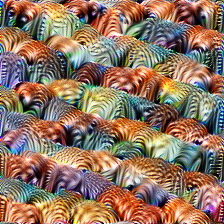
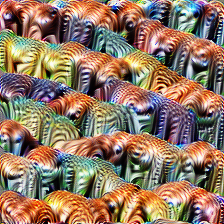
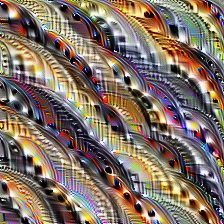
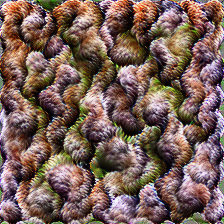
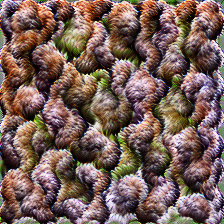
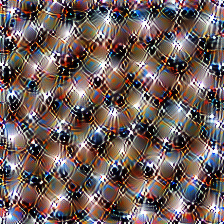
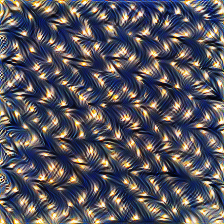
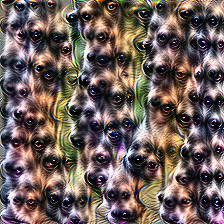
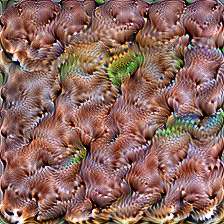
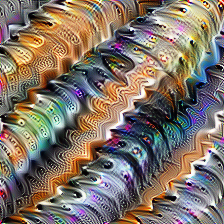
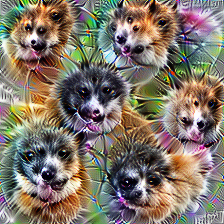
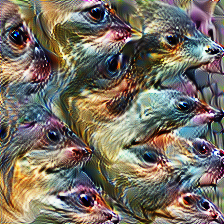
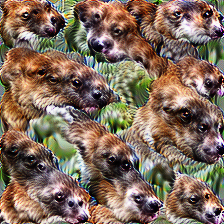

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = custom_resnet.resnet18(weights = "pretrained").to(device).eval()

param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0].item(), batch = 0) + objectives.channel(layers[1],channel_list[1].item(), batch = 1) + objectives.channel(layers[2],channel_list[2].item(), batch = 2) + objectives.channel(layers[3],channel_list[3].item(), batch = 3) + \
      objectives.channel(layers[4],channel_list[4].item(), batch = 4) + objectives.channel(layers[5],channel_list[5].item(), batch = 5) + objectives.channel(layers[6],channel_list[6].item(), batch = 6) + objectives.channel(layers[7],channel_list[7].item(), batch = 7) + \
      objectives.channel(layers[8],channel_list[8].item(), batch = 8) + objectives.channel(layers[9],channel_list[9].item(), batch = 9) + objectives.channel(layers[10],channel_list[10].item(), batch = 10) + objectives.channel(layers[11],channel_list[11].item(), batch = 11) + \
      objectives.channel(layers[0],channel_list[0].item(), batch = 12) + objectives.channel(layers[1],channel_list[1].item(), batch = 12) + objectives.channel(layers[2],channel_list[2].item(), batch = 12) + objectives.channel(layers[3],channel_list[3].item(), batch = 12) + \
      objectives.channel(layers[4],channel_list[4].item(), batch = 12) + objectives.channel(layers[5],channel_list[5].item(), batch = 12) + objectives.channel(layers[6],channel_list[6].item(), batch = 12) + objectives.channel(layers[7],channel_list[7].item(), batch = 12) + \
      objectives.channel(layers[8],channel_list[8].item(), batch = 12) + objectives.channel(layers[9],channel_list[9].item(), batch = 12) + objectives.channel(layers[10],channel_list[10].item(), batch = 12) + objectives.channel(layers[11],channel_list[11].item(), batch = 12)

_ = render.render_vis(model, obj, param_f, preprocess = True, show_inline = True, thresholds=(512,))

## Layer 4 Visualisations

### Maximally activating channels for Labrador Retriever in layer 4

#### Collecting channels

In [ ]:
channel_list = []

layers = ['layer4_0_conv1',
 'layer4_0_bn1',
 'layer4_0_relu',
 'layer4_0_conv2',
 'layer4_0_bn2',
 'layer4_0_downsample_0',
 'layer4_0_downsample_1',
 'layer4_1_conv1',
 'layer4_1_bn1',
 'layer4_1_relu',
 'layer4_1_conv2',
 'layer4_1_bn2',]

label = 'Labrador retriever'

for l in layers:
  model = custom_resnet.resnet18(weights = "pretrained").to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  channel_list.append(attr.max(-1)[0].topk(1)[1])

  for handle in handles:
    handle.remove()

In [ ]:
print(channel_list)

[tensor([83]), tensor([505]), tensor([505]), tensor([418]), tensor([418]), tensor([418]), tensor([418]), tensor([460]), tensor([45]), tensor([45]), tensor([204]), tensor([204])]


#### Visualising all channels and combined channel objective

100%|██████████| 512/512 [00:32<00:00, 15.64it/s]



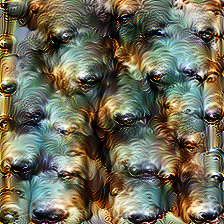
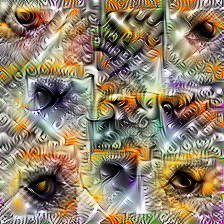
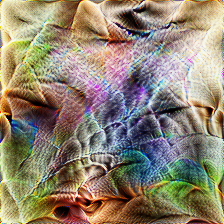
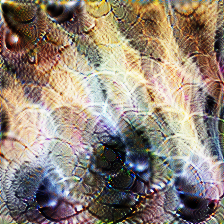
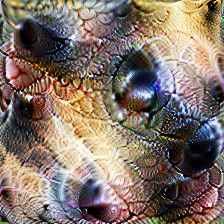
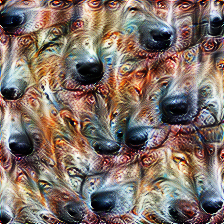
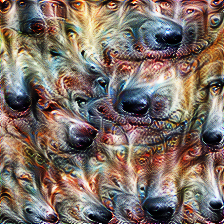
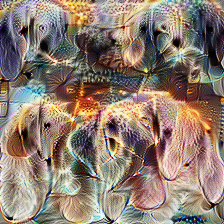
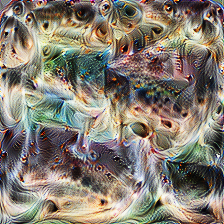
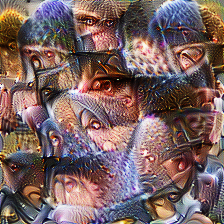
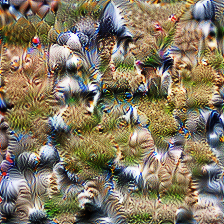
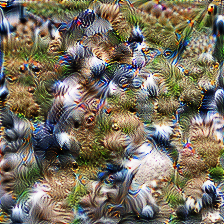
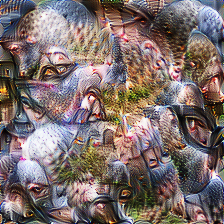

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = custom_resnet.resnet18(weights = "pretrained").to(device).eval()

param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0].item(), batch = 0) + objectives.channel(layers[1],channel_list[1].item(), batch = 1) + objectives.channel(layers[2],channel_list[2].item(), batch = 2) + objectives.channel(layers[3],channel_list[3].item(), batch = 3) + \
      objectives.channel(layers[4],channel_list[4].item(), batch = 4) + objectives.channel(layers[5],channel_list[5].item(), batch = 5) + objectives.channel(layers[6],channel_list[6].item(), batch = 6) + objectives.channel(layers[7],channel_list[7].item(), batch = 7) + \
      objectives.channel(layers[8],channel_list[8].item(), batch = 8) + objectives.channel(layers[9],channel_list[9].item(), batch = 9) + objectives.channel(layers[10],channel_list[10].item(), batch = 10) + objectives.channel(layers[11],channel_list[11].item(), batch = 11) + \
      objectives.channel(layers[0],channel_list[0].item(), batch = 12) + objectives.channel(layers[1],channel_list[1].item(), batch = 12) + objectives.channel(layers[2],channel_list[2].item(), batch = 12) + objectives.channel(layers[3],channel_list[3].item(), batch = 12) + \
      objectives.channel(layers[4],channel_list[4].item(), batch = 12) + objectives.channel(layers[5],channel_list[5].item(), batch = 12) + objectives.channel(layers[6],channel_list[6].item(), batch = 12) + objectives.channel(layers[7],channel_list[7].item(), batch = 12) + \
      objectives.channel(layers[8],channel_list[8].item(), batch = 12) + objectives.channel(layers[9],channel_list[9].item(), batch = 12) + objectives.channel(layers[10],channel_list[10].item(), batch = 12) + objectives.channel(layers[11],channel_list[11].item(), batch = 12)

_ = render.render_vis(model, obj, param_f, preprocess = True, show_inline = True, thresholds=(512,))

### Maximally activating channels for Tiger cat in layer 4

#### Collecting channels

In [ ]:
channel_list = []

layers = ['layer4_0_conv1',
 'layer4_0_bn1',
 'layer4_0_relu',
 'layer4_0_conv2',
 'layer4_0_bn2',
 'layer4_0_downsample_0',
 'layer4_0_downsample_1',
 'layer4_1_conv1',
 'layer4_1_bn1',
 'layer4_1_relu',
 'layer4_1_conv2',
 'layer4_1_bn2',]

label = 'tiger cat'

for l in layers:
  model = custom_resnet.resnet18(weights = "pretrained").to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  channel_list.append(attr.max(-1)[0].topk(1)[1])

  for handle in handles:
    handle.remove()

In [ ]:
print(channel_list)

[tensor([327]), tensor([327]), tensor([327]), tensor([237]), tensor([473]), tensor([473]), tensor([473]), tensor([140]), tensor([140]), tensor([140]), tensor([68]), tensor([68])]


#### Visualising all channels and combined channel objective

100%|██████████| 512/512 [00:33<00:00, 15.41it/s]



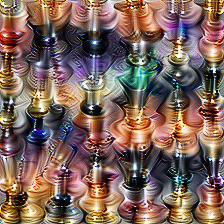
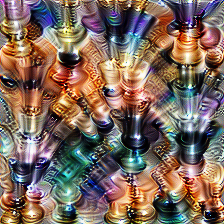
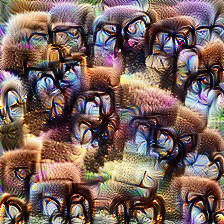
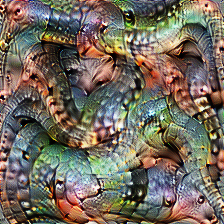
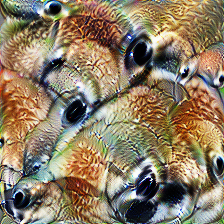
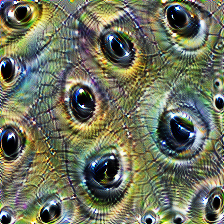
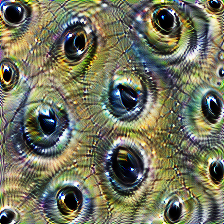
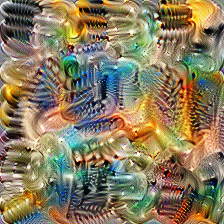
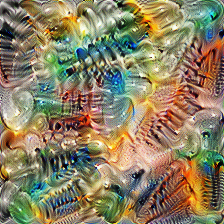
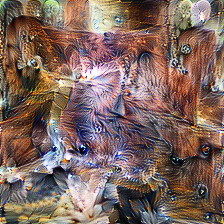
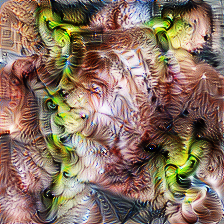
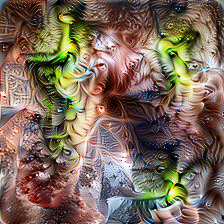
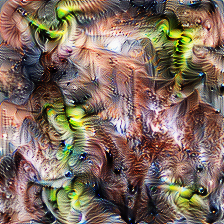

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = custom_resnet.resnet18(weights = "pretrained").to(device).eval()

param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0].item(), batch = 0) + objectives.channel(layers[1],channel_list[1].item(), batch = 1) + objectives.channel(layers[2],channel_list[2].item(), batch = 2) + objectives.channel(layers[3],channel_list[3].item(), batch = 3) + \
      objectives.channel(layers[4],channel_list[4].item(), batch = 4) + objectives.channel(layers[5],channel_list[5].item(), batch = 5) + objectives.channel(layers[6],channel_list[6].item(), batch = 6) + objectives.channel(layers[7],channel_list[7].item(), batch = 7) + \
      objectives.channel(layers[8],channel_list[8].item(), batch = 8) + objectives.channel(layers[9],channel_list[9].item(), batch = 9) + objectives.channel(layers[10],channel_list[10].item(), batch = 10) + objectives.channel(layers[11],channel_list[11].item(), batch = 11) + \
      objectives.channel(layers[0],channel_list[0].item(), batch = 12) + objectives.channel(layers[1],channel_list[1].item(), batch = 12) + objectives.channel(layers[2],channel_list[2].item(), batch = 12) + objectives.channel(layers[3],channel_list[3].item(), batch = 12) + \
      objectives.channel(layers[4],channel_list[4].item(), batch = 12) + objectives.channel(layers[5],channel_list[5].item(), batch = 12) + objectives.channel(layers[6],channel_list[6].item(), batch = 12) + objectives.channel(layers[7],channel_list[7].item(), batch = 12) + \
      objectives.channel(layers[8],channel_list[8].item(), batch = 12) + objectives.channel(layers[9],channel_list[9].item(), batch = 12) + objectives.channel(layers[10],channel_list[10].item(), batch = 12) + objectives.channel(layers[11],channel_list[11].item(), batch = 12)

_ = render.render_vis(model, obj, param_f, preprocess = True, show_inline = True, thresholds=(512,))